~ Import Libraries ~

In [1]:
import csv
import keras
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

random_seed = 42

~ Import Data ~

In [2]:
dataset = 'C:/Users/hgheb/OneDrive/Desktop/gesture-recognition-project-latest/model/keypoint_classifier/keypoint.csv'
model_path = 'C:/Users/hgheb/OneDrive/Desktop/gesture-recognition-project-latest/model/keypoint_classifier/keypoint_classifier.keras'

~ Assign Number of Classifiers ~

In [3]:
num_classes = 11  # Number of gestures (can be found in the "keypoint_classifier_label.csv" file")

~ Read Dataset ~

In [4]:
x_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

# Reshape dataset to include time steps
time_steps = 10
num_features = 21 * 2

num_samples = x_dataset.shape[0] // time_steps * time_steps
x_dataset = x_dataset[:num_samples].reshape(-1, time_steps, num_features)
y_dataset = y_dataset[:num_samples // time_steps * time_steps:time_steps]

# Split dataset for training and testing
x_train, x_test, y_train, y_test = train_test_split(x_dataset, y_dataset, train_size=0.75, random_state=random_seed)

~ Plot Dataset ~

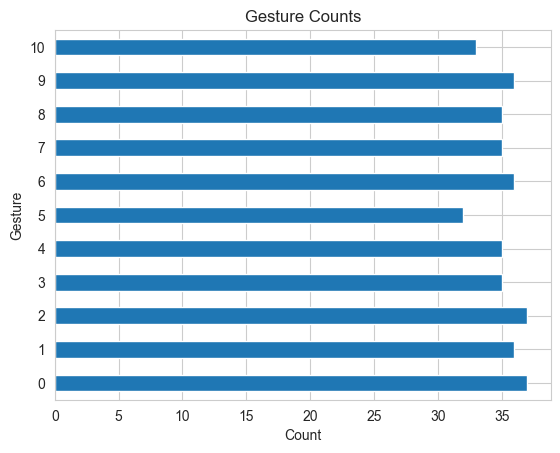

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), array([37, 36, 37, 35, 35, 32, 36, 35, 35, 36, 33], dtype=int64))


In [5]:
# Classes count (num of gestures)

# Forward = 0 ; Back = 1 ; Up = 2 ; Down = 3 ; Left = 4 ; Right = 5
# Take Off = 6 ; Land = 7 ; Flip Forward = 8 ; Flip Backward = 9

# Count unique values
counts = np.unique(y_dataset, return_counts=True)
categories, count_values = counts

# Create a DataFrame
df = pd.DataFrame({'Category': categories, 'Count': count_values})

# Plot horizontal bar chart
df.plot(kind='barh', x='Category', y='Count', color='#1f77b4', legend=False)

# Add labels
plt.xlabel('Count')
plt.ylabel('Gesture')
plt.title('Gesture Counts')
plt.show()

print(counts)

# Train Model

~ Build LSTM Neural Network ~

In [6]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(time_steps, num_features)),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LSTM(48),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 64)            27392     
                                                                 
 dropout (Dropout)           (None, 10, 64)            0         
                                                                 
 batch_normalization (BatchN  (None, 10, 64)           256       
 ormalization)                                                   
                                                                 
 lstm_1 (LSTM)               (None, 48)                21696     
                                                                 
 dropout_1 (Dropout)         (None, 48)                0         
                                                                 
 batch_normalization_1 (Batc  (None, 48)               192       
 hNormalization)                                        

In [7]:
# Model checkpoint callback
cp = tf.keras.callbacks.ModelCheckpoint(model_path, verbose=1, save_weights_only=False)

# Early Stopping - ending training early as to prevent an increase in loss (overfitting)
es = tf.keras.callbacks.EarlyStopping(patience=15, verbose=1)

# Model compilation
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [8]:
history = model.fit(x_train, y_train, epochs=1000, batch_size=32, validation_data=(x_test, y_test), callbacks=[cp, es])

Epoch 1/1000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6080 - accuracy: 0.1250 
Epoch 1: saving model to C:/Users/hgheb/OneDrive/Desktop/gesture-recognition-project-latest/model/keypoint_classifier\keypoint_classifier.keras
10/10 [==============================] - 4s 96ms/step - loss: 2.5941 - accuracy: 0.1207 - val_loss: 2.3156 - val_accuracy: 0.3093
Epoch 2/1000
 8/10 [=======================>......] - ETA: 0s - loss: 2.0380 - accuracy: 0.2930
Epoch 2: saving model to C:/Users/hgheb/OneDrive/Desktop/gesture-recognition-project-latest/model/keypoint_classifier\keypoint_classifier.keras
10/10 [==============================] - 0s 14ms/step - loss: 2.0275 - accuracy: 0.3000 - val_loss: 2.2357 - val_accuracy: 0.4227
Epoch 3/1000
 9/10 [==========================>...] - ETA: 0s - loss: 1.7954 - accuracy: 0.3924
Epoch 3: saving model to C:/Users/hgheb/OneDrive/Desktop/gesture-recognition-project-latest/model/keypoint_classifier\keypoint_classifier.keras
10/10 [============

# Test Model

In [9]:
# Model evaluation
val_loss, val_acc = model.evaluate(x_test, y_test, batch_size=64)

2/2 [==============================] - 0s 5ms/step - loss: 0.0565 - accuracy: 0.9897


In [10]:
# Loading the saved model
model = tf.keras.models.load_model(model_path)

In [11]:
# Inference test
predict_result = model.predict(np.array([x_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 443ms/step
[1.1682546e-04 9.5049654e-05 4.7011144e-04 3.8341433e-03 2.7188327e-05
 3.5993389e-06 5.9041395e-06 1.2272768e-04 9.8842233e-01 6.8988353e-03
 3.2631110e-06]
8


# Data Analysis

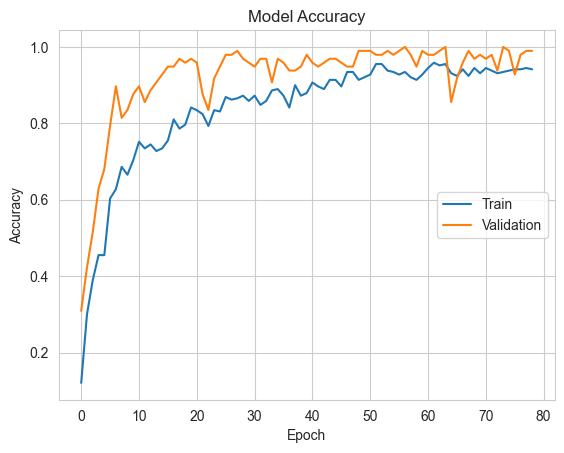

In [21]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='right')
plt.show()

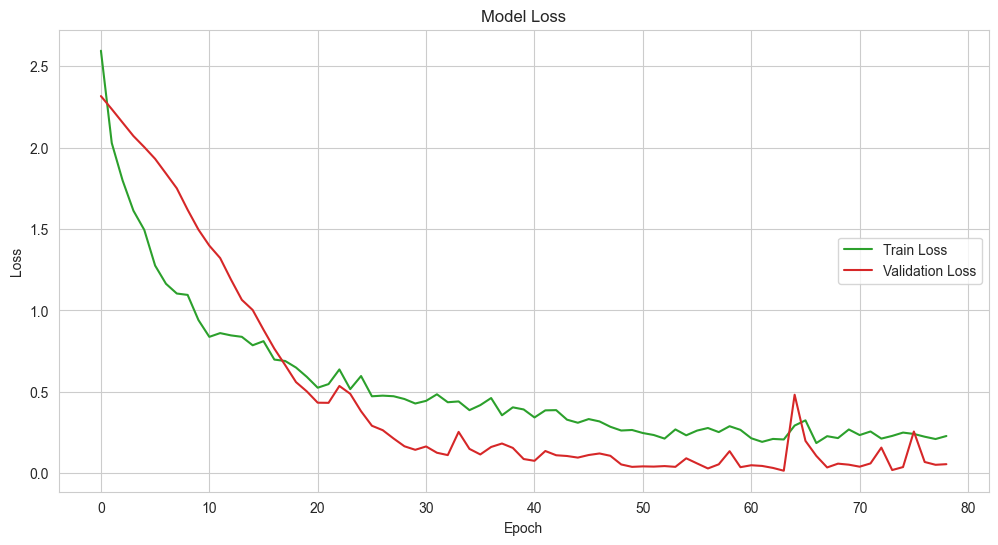

In [22]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss', color='tab:green')
plt.plot(history.history['val_loss'], label='Validation Loss', color='tab:red')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='right')
plt.show()

~ Confusion Matrix ~

4/4 [==============================] - 0s 6ms/step


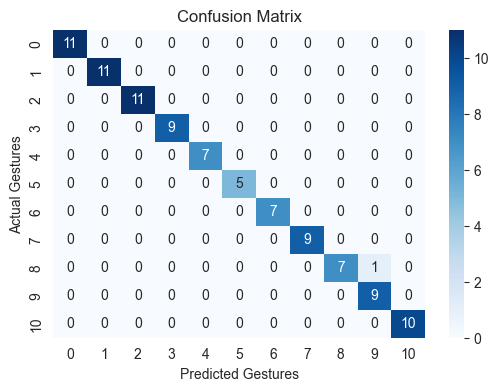

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00        11
           3       1.00      1.00      1.00         9
           4       1.00      1.00      1.00         7
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         7
           7       1.00      1.00      1.00         9
           8       1.00      0.88      0.93         8
           9       0.90      1.00      0.95         9
          10       1.00      1.00      1.00        10

    accuracy                           0.99        97
   macro avg       0.99      0.99      0.99        97
weighted avg       0.99      0.99      0.99        97



In [24]:
def print_confusion_matrix(y_true, y_pred, report=True):
    conf_matrix = confusion_matrix(y_true, y_pred, labels = sorted(list(set(y_true))))

    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'],
            yticklabels=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'],)
    plt.xlabel('Predicted Gestures')
    plt.ylabel('Actual Gestures')
    plt.title('Confusion Matrix')
    plt.show()
    
    if report:
         print('Classification Report')
         print(classification_report(y_test, y_pred))
        
Y_pred = model.predict(x_test)
y_pred = np.argmax(Y_pred, axis=1)
print_confusion_matrix(y_test, y_pred)